# GeoPandas Basics

## 总结

- 用DataFrame牛逼

## 0 Imports

The following packages will be needed for this notebook. Make sure you have them installed in your environment!

In [1]:
# Imports:
import geopandas as gpd
import pandas as pd
from math import cos, sin, radians, sqrt
from matplotlib import pyplot as plt
from shapely.geometry import Point, box
import random

## 1 Introduction

GeoPandas is a python module which is built upon pandas - one of the most prominent data analysis libraries in python. Further information on pandas, including its documentation can be found here: https://pandas.pydata.org/.
GeoPandas' aim is to provide an easy-to-use data analysis environment for geospatial data. It allows for spatial operations on geometric types. Geometric types in GeoPandas are defined by shapely objects, which you already know from the previous exercise. 
We will use GeoPandas in many of the exercises of this labcourse. Hence, this notebook will introduce you to its main concepts, including concepts that are also valid in pandas. Nevertheless, due to its close relation to pandas you may also want to look up the pandas documentation from time to time, if you need help during any of the exercises to come.
Further information on GeoPandas can be found in the GeoPandas documentation: http://geopandas.org/


## 2 GeoSeries

One of the basic structures of pandas is the Series. A Series is a one-dimensional array which contains information about related data (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html). In addition to the data, a Series also comprises a label for each data piece. This label is also called "index". There are as many labels in a Series as there are rows. Labels, can, but do not need to be unique. If no index is specified explicitely, the index is generated automatically. The following example shows the initialization of a simple pandas Series:

In [2]:
# Some data to generate a Series
my_data = [1,2,3]
my_labels = ["a", "b", "c"]

# Initialize the Series, once with a custom index and once with automatic indexing
my_series_custom_ind = pd.Series(my_data, index=my_labels)
my_series_automatic_ind = pd.Series(my_data)

# Print the result
print("Series with custom indexing: \n"+str(my_series_custom_ind))
print("\nSeries with automatic indexing: \n"+str(my_series_automatic_ind))

Series with custom indexing: 
a    1
b    2
c    3
dtype: int64

Series with automatic indexing: 
0    1
1    2
2    3
dtype: int64


While a pandas Series object can hold a number of different data types, GeoPandas offers a much more specified data container called a GeoSeries. A GeoSeries can only hold shapely geometry objects, but is well suited to perform operations on these. Other than that, it behaves just like a pandas Series object. Therefore, many operations that work with pandas Series objects will also work on GeoSeries objects.
Just like the pandas Series, a GeoSeries stores related data. Because this data is by nature of a geometric type, there are two possible interpretations of the contents of a GeoSeries.

A GeoSeries can be interpreted as:
    1.) A set of related geometries regarding their content (e.g. boundaries of different countries)
    2.) A set containing different representations of the same geometry (e.g. country boundaries over the centuries)
    
We will have a look at both types of GeoSeries in the next two sections (2.1 and 2.2). 

### 2.1 GeoSeries -  Set of Related Geometries

The first interpretation of a GeoSeries is that the contents of the GeoSeries are a set of related geometries. This geometries can be related in many ways, but in many cases they are different geometric objects that describe real world geometries of the same type, e.g. all the countries of europe. 
To make life easier, we will use a scenario with seven very simple countries named a, b, c, d, e, f and g whose borders are all defined by shapely boxes:

In [3]:
# Let's define seven different countries named a, b, c, d, e, f and g and assign them a border object 
COUNTRY_NAMES = ['a', 'b', 'c', 'd', 'e', 'f', 'g'] # Index of the countries GeoSeries = Name of the country
COUNTRY_BOXES = [box(0,0,3,2), box(0,2,1,7), box(1,4,2,7), box(1,2,4,4), box(3,1,5,2), box(4,2,6,5), box(3,4,4,5)] # Geometry column of the GeoSeries = Border of the country

From this raw data we can create a GeoSeries object. A GeoSeries object is initialized just like a Series object in pandas:

In [4]:
# Let's create a GeoSeries with the names as index (if no index is supplied, the entries will be numbered 1,2,...N)
countries_gs = gpd.GeoSeries(COUNTRY_BOXES, index=COUNTRY_NAMES)

By plotting the contents of the GeoSeries using knowledge from the shapely basics notebook we obtain a map plot of our seven countries. We will often plot the countries GeoSeries in this notebook. To make plotting a little simpler and unify the appearance of the countries plots, we define a set of functions to easily handle country plots.

In [5]:
# A function that labels the countries in a map plot
def plot_names_centroids_countries():
    N = len(COUNTRY_NAMES)
    for i in range(0,N):
        plt.text(COUNTRY_BOXES[i].centroid.x, COUNTRY_BOXES[i].centroid.y, COUNTRY_NAMES[i], horizontalalignment='center')

# Define a function to scale a figure to the specified sizes
def scale_plot(xlim, ylim, xfigsize, yfigsize, fig):
    fig.set_size_inches((xfigsize, yfigsize)) # Define the output size in inches
    plt.xlim(xlim) # Define the x limit of the plot
    plt.ylim(ylim) # Define the y limit of the plot

# A function to scale and label all plots of our country data
def setup_country_plot(fig, title):
    plot_names_centroids_countries()
    plt.title(title)
    plt.xlabel("x [1000*km]")
    plt.ylabel("y [1000*km]")
    scale_plot(*MAP_SCALE, *MAP_FIGSIZE, fig)

With the newly defined functions we can easily print a nice-looking map comprising our artificial countries:

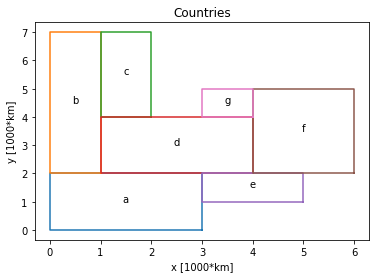

In [6]:
# Let's print our map (remember the shapely basics notebook)
fig = plt.figure()
for poly in countries_gs:
    plt.plot(*poly.exterior.xy)
    
# Save map style (we will use this to scale all country maps plotted in this notebook equally)
x_lim_map = plt.xlim()
y_lim_map = plt.ylim()
MAP_SCALE = [x_lim_map, y_lim_map]
MAP_FIGSIZE = plt.gcf().get_size_inches()

setup_country_plot(fig, title="Countries")


### 2.2 GeoSeries - Different Representations of one Geometry

As mentioned before, a GeoSeries can not only store a set of related but different geometry (Section 2.1). It can also be used to store different representations of the same geometry. An example application for this interpretation is the ball throw: while the geometry under observation remains the same (here: a ball represented by a point), its position changes. Another example in the context of mobility data analysis would be the position of a driving car. But let us stick to the ball throw for a moment. A simple simulation can be used to generate a GeoSeries:

In [7]:
# A function to evaluate all state variables of a thrown ball at time t when the initial state is known
def ball_throw(x_0, y_0, v_0, theta, t):

    g = 9.81 # Gravitational constant

    v_x = v_0*cos(theta) # Velocity in x-direction at time t
    v_y = v_0*sin(theta) - g*t # Velocity in y-direction at time t

    x = x_0 + v_0*cos(theta)*t # Location in x-direction at time t
    y = y_0 + v_0*sin(theta)*t-0.5*g*t*t # Location in y-direction at time t

    return x, v_x, y, v_y

# Let's simulate a thrown ball with the following parameters:

# Simulation parameters
start_t_s = 0
end_t_s = 1
step_width_ms = 10
times = list(range(start_t_s*1000, end_t_s*1000, step_width_ms))
times = [t/1000 for t in times]

# Initial conditions
x_0 = 0
y_0 = 5
v_0 = 3
theta = radians(70)

# Simulation
state_list = [ball_throw(x_0, y_0, v_0, theta, t) for t in times]

# Create shapely_points
point_list = [Point(state[0], state[2]) for state in state_list]

# Create a GeoSeries and use the time as index
ball_throw_gs = gpd.GeoSeries(point_list, index = times)

Similar to the countries example we make our lifes easier by defining a plotting routine for the ball throw, which we can later use to generate beautiful plots of our examples:

In [8]:
# A function to scale and label all plots of our country data
def setup_ball_throw_plot(fig, title):
    plt.title(title)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    scale_plot(*BALL_THROW_SCALE, *BALL_THROW_FIGSIZE, fig)

Let's have a look at the ball throw we just simulated and stored in a GeoSeries object:

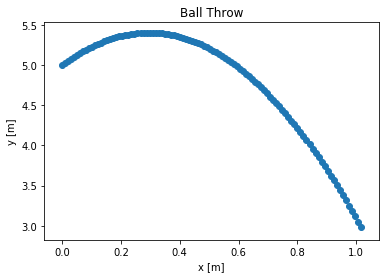

In [9]:
# Plot the ball throw GeoSeries
fig = plt.figure()
for pt in ball_throw_gs:
    plt.scatter(*pt.xy, color="C0")

# Save ball throw style
x_lim_map = plt.xlim()
y_lim_map = plt.ylim()
BALL_THROW_SCALE = [x_lim_map, y_lim_map]
BALL_THROW_FIGSIZE = plt.gcf().get_size_inches()

# Scale and label ball throw plot
setup_ball_throw_plot(fig, title="Ball Throw")

### 2.3 Accessing a GeoSeries

In Sections 2.1 and 2.2 different GeoSeries objects were created. One of the GeoSeries contains the borders of seven fictive countries, the other one the simulation results of a ball throw. For data analysis, the data in the newly created GeoSeries needs to be accessed. Hence, Section 2.3 deals with different ways of data access in (Geo-)Series. You will use most of these access methods in the remainder of this labcourse. Please note, that this is not GeoPandas specific, data access works all the same in pandas. For further information on data access in Series and DataFrames (which you will learn about in Section 3), please refer to: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

#### 2.3.1 Retrieving individual objects

This section deals with different ways of retrieving individual objects from a (Geo)Series. After each example, the result is visualized to check the result. 

The first way to retrieve data from a Series is the index (label): 

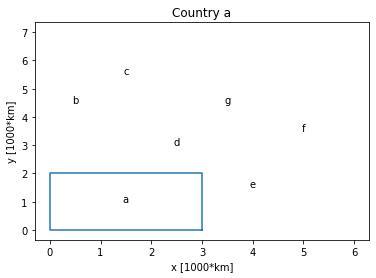

In [10]:
# Using the index, data can be retrieved from a GeoSeries using square brackets
a = countries_gs["a"]

# Checking the result
fig = plt.figure()
plt.plot(*a.exterior.xy)
setup_country_plot(fig, title="Country a")

An alternative way to access data by its index is the loc attribute of a (Geo)Series:

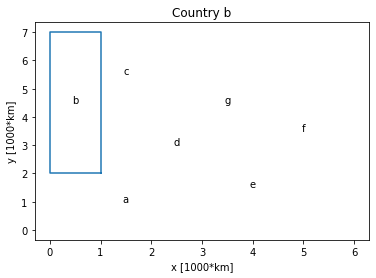

In [11]:
# An alternative to using the index to retrieve a row is the loc attribute
b = countries_gs.loc["b"]

# Checking the result
fig = plt.figure()
plt.plot(*b.exterior.xy)
setup_country_plot(fig, title="Country b")

Instead of using indices/labels one can also work with positional indices. To retrieve data from a (Geo)Series using positional indexing, the .iloc-attribute is used. Remember: Indexing in python starts with 0 most of the time! 

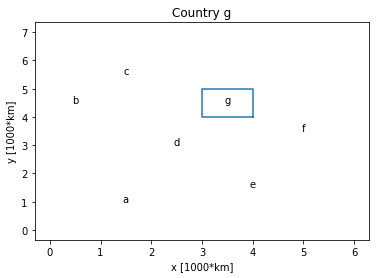

In [12]:
# Data can also be retrieved using positional indices using iloc
g = countries_gs.iloc[6]

# Checking the result
fig = plt.figure()
plt.plot(*g.exterior.xy)
setup_country_plot(fig, title="Country g")

#### 2.3.2 Retrieving multiple objects

Many times, one needs to retrieve multiple elements of a (Geo)Series, rather than individual ones. This can be done in multiple ways:

##### Lists

The basic concepts of retrieving individual objects can also be used to select multiple elements if lists are used, i.e. index selection, iloc selection and loc selection also work when multiple indexes are passed in a list structure:

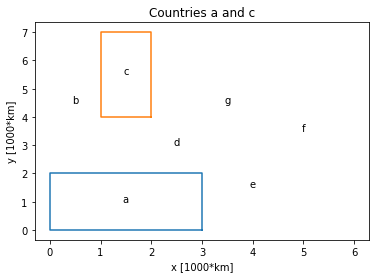

In [13]:
# Selecting multiple elements of a GeoSeries using a list of indices
a_c = countries_gs[["a", "c"]]

# Checking the result
fig = plt.figure()
for poly in a_c:
    plt.plot(*poly.exterior.xy)
setup_country_plot(fig, title="Countries a and c")

Analogous to index selection, loc selection can also be used together with lists. Use a loc selection to select countries d and e from the countries GeoSeries and store the result in a variable called d_e! Take a look at the plot. Have you selected the countries correctly?

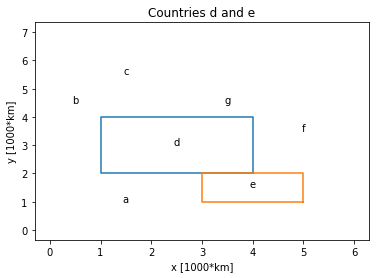

In [14]:
# Use loc selection together with a list to select countries d and e!
d_e = countries_gs[["d", "e"]]



# Checking the result
fig = plt.figure()
for poly in d_e:
    plt.plot(*poly.exterior.xy)
setup_country_plot(fig, title="Countries d and e")

Now use iloc selection to select countries f and g and store the selected elements of the countries GeoSeries in a variable called f_g.

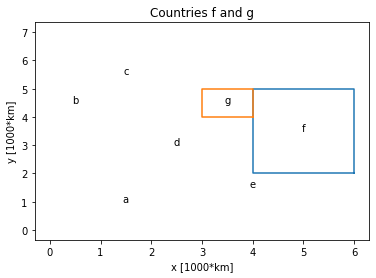

In [15]:
# Use iloc selection together with a list to select countries f and g!
f_g = countries_gs[[5, 6]]



# Checking the result
fig = plt.figure()
for poly in f_g:
    plt.plot(*poly.exterior.xy)
setup_country_plot(fig, title="Countries f and g")

##### Slicing

Because a (Geo)Series is an ordered array of data, slicing is possible as well. The ":" operator is used to select slices of subsequent data from a (Geo)Series. Again, the basic concepts of index selection, loc and iloc selection are adapted:

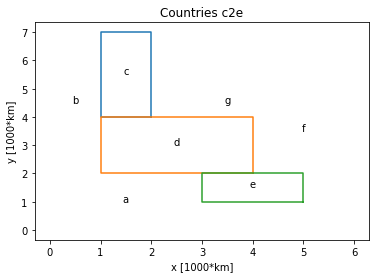

In [16]:
# Selecting multiple elements of a GeoSeries using a slice of indices
c2e = countries_gs["c":"e"]
# 其实这里是相当于取index 'c'和index 'e'，然后这之间的index全部切片，不过不同于用需要切片，这里包含'e'

# Checking the result
fig = plt.figure()
for poly in c2e:
    plt.plot(*poly.exterior.xy)
setup_country_plot(fig, title="Countries c2e")

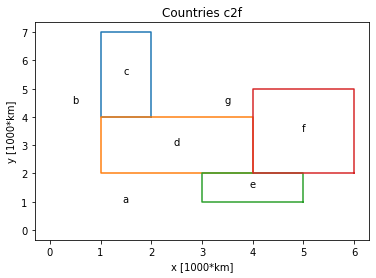

In [17]:
# Selecting multiple elements of a GeoSeries using a slice of indices with the .loc attribute
c2f = countries_gs.loc["c":"f"]

# Checking the result
fig = plt.figure()
for poly in c2f:
    plt.plot(*poly.exterior.xy)
setup_country_plot(fig, title="Countries c2f")

Use iloc selection to select countries b, c, and d by slicing:

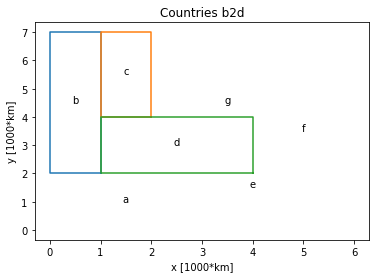

In [18]:
# Use iloc selection and slicing to select countries b, c and d!
b2d = countries_gs.iloc[1:4]
# 这里就是含1不包含4


# Checking the result
fig = plt.figure()
for poly in b2d:
    plt.plot(*poly.exterior.xy)
setup_country_plot(fig, title="Countries b2d")

##### Conditional Selection

One of the most powerful ways to select data from a (Geo)Series is conditional selection. Using conditional selection, one can select all elements in a (Geo)Series for which a condition is true. There are two ways to achieve this: 

1. Use a boolean array
2. Use a callable that evaluates to either true or false (e.g. a lambda function https://www.w3schools.com/python/python_lambda.asp)

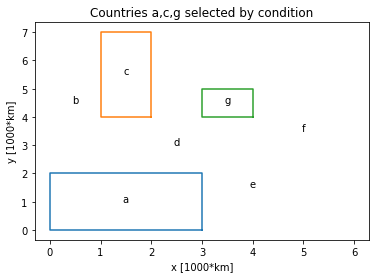

In [19]:
# Using a boolean array/list
bool_list = [index in ["a", "g", "c"] for index in countries_gs.index]
a_g_c = countries_gs[bool_list]

# Checking the result
fig = plt.figure()
for poly in a_g_c:
    plt.plot(*poly.exterior.xy)
setup_country_plot(fig, title="Countries a,c,g selected by condition")

In [20]:
print(bool_list)

[True, False, True, False, False, False, True]


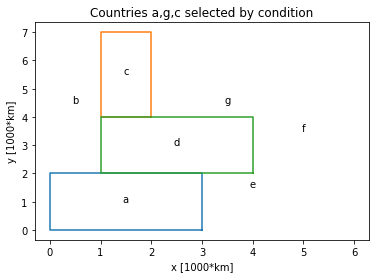

In [21]:
# Using a callable to select all countries that touch b
# lambda是匿名函数，这里touch表示有和"b"所在的图形接触的
a_g_c = countries_gs[lambda x: x.touches(countries_gs["b"])] # See the shapely documentation for the "touches" operation

# Checking the result
fig = plt.figure()
for poly in a_g_c:
    plt.plot(*poly.exterior.xy)
setup_country_plot(fig, title="Countries a,g,c selected by condition")

In [22]:
print(a_g_c)

a    POLYGON ((3.00000 0.00000, 3.00000 2.00000, 0....
c    POLYGON ((2.00000 4.00000, 2.00000 7.00000, 1....
d    POLYGON ((4.00000 2.00000, 4.00000 4.00000, 1....
dtype: geometry


Note: Accessing data from a more elaborate data structure like a DataFrame (pandas) or a GeoDataFrame (GeoPandas) works similarily, but returns different objects than data selection in (Geo)Series. You will learn about the concept of GeoDataFrames in the next section. Please make yourself familiar with data access from (Geo)DataFrames using https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html and also use this link as a goto resource whenever you get stuck in any exercise regarding (Geo)DataFrames!

## 3 GeoDataFrame

In real life applications, individual observations contain more than just one type of information. Such data can conveniently be stored in a table-like data structure. For this purpose, pandas offers a so called DataFrame object. A DataFrame is a two-dimensional tabular data structure with an index (labels). 

In [23]:
# Data for the DataFrame
cities = ["Berlin", "Paris", "London", "Rome", "New York"]
city_population = [3575000, 2141000, 8136000, 2873000, 8623000]
city_country = ["Germany", "France", "Great Britain", "Italy", "United States"]
city_continent = ["Europe", "Europe", "Europe", "Europe", "North America"]
data = {"population":city_population, "country":city_country, "continent": city_continent}

# Create the DataFrame
cities_df = pd.DataFrame(data = data, index = cities)

# Show the DataFrame
print(cities_df)

          population        country      continent
Berlin       3575000        Germany         Europe
Paris        2141000         France         Europe
London       8136000  Great Britain         Europe
Rome         2873000          Italy         Europe
New York     8623000  United States  North America


The corresponding GeoPandas class is called a GeoDataFrame. It is used when additional information shall be stored along with geometric information. A GeoDataFrame always has a geometry column, which is defined by a GeoSeries containing shapely objects. In addition to the geometry column, it can store an arbitrary number of additional columns that provide more information regarding the geometry. The following sections introduce you to the basics of GeoDataFrames.

### 3.1 Initializing a GeoDataFrame

A GeoDataFrame can easily be initialized using a GeoSeries:

In [24]:
# Countries GeoDataFrame
countries_gpd = gpd.GeoDataFrame(geometry=countries_gs)

# Ball throw GeoDataFrame
ball_throw_gpd = gpd.GeoDataFrame(geometry=ball_throw_gs)

### 3.2 Visualization of a GeoDataFrame

One strength of GeoDataFrames is that they can easily be plotted using the .plot() method. plot() is compatible with matplotlib and, hence, pyplot. It can take matplotlib arguments to customize the plot style.

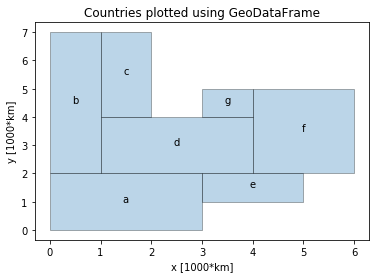

In [25]:
# Plotting is easy using GeoDataFrames
ax = countries_gpd.plot(alpha=0.3, edgecolor='k')

# The general country plotting framework
ax.set_aspect("auto")
setup_country_plot(ax.figure, title="Countries plotted using GeoDataFrame")

As you can see from the countries and ball throw example, geopandas automatically prints the geometry and uses different plot functions of matplotlib to do so. You do not have to use a different function for polygons, points or any other geometry type. Just use the .plot() function. Try it with the ball throw GeoDataFrame!

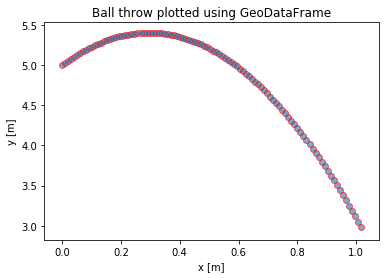

In [26]:
# Use the plot function on the ball throw GeoDataFrame to plot the ball throw!
ax = ball_throw_gpd.plot(alpha=0.6, edgecolor='red')



# The general ball throw plotting framework
ax.set_aspect("auto")
setup_ball_throw_plot(ax.figure, title="Ball throw plotted using GeoDataFrame")

### 3.3 Adding Data to a GeoDataFrame

There are several ways of adding data to a (Geo)DataFrame. For further information on the matter see the pandas or geopandas documentation. To add a whole column however, it is possible to initialize it to None and add data with the corresponding length.

In [27]:
# Add columns to the GeoDataFrames and initialize them with None
countries_gpd["population", "area"] = None
ball_throw_gpd["velocity"] = None

# Add data to the new columns
# Data can be added using Iterables. Data must be as long as the column
# Note: In GeoDataFrames shapely functions and properties are applied to/received for 
# the whole geometry column. If a column is specified, the function is applied to this column instead.
population_max_density = 1000
countries_gpd["area"] = countries_gpd.geometry.area
countries_gpd["population"] = countries_gpd.area.apply(func=lambda x: 1000*x*random.randint(100,population_max_density)) 

velocities = [(state[1], state[3]) for state in state_list]
total_velocities = [sqrt(v[0]*v[0]+v[1]*v[1]) for v in velocities]

ball_throw_gpd["velocity"] = total_velocities

### 3.4 Advanced Visualization of a GeoDataFrame

Oftentimes, data columns of a GeoDataFrame other than the geometry column shall be visualized. To do so, colormaps can be used. Just pass the column that is supposed to be visualized to the .plot() function and define a colormap to use. The result is a so-called coropleth map (https://en.wikipedia.org/wiki/Choropleth_map) which you have surely seen before.

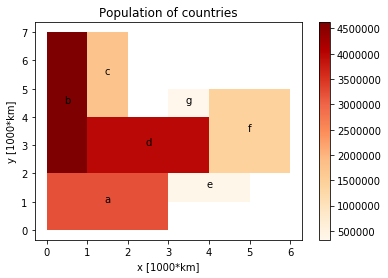

In [28]:
# The new data can also be displayed in the plot
# For available colormaps see https://matplotlib.org/examples/color/colormaps_reference.html
ax = countries_gpd.plot(column="population", cmap='OrRd', legend=True)

# The general country plotting framework
ax.set_aspect("auto")
setup_country_plot(ax.figure, title="Population of countries")

Now create a plot for the ball throw example in which the points of the ball throw are colored according to the current velocity of the ball. Use the same colormap as in the countries example and display a legend

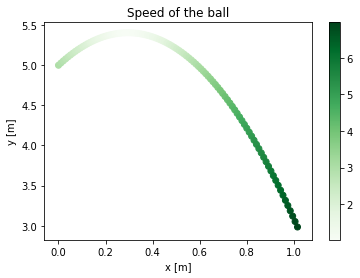

In [29]:
# Plot the ball throw example and color it according to the velocity!
ax = ball_throw_gpd.plot(column="velocity", cmap='Greens',legend=True)



# The general ball throw plotting framework
ax.set_aspect("auto")
setup_ball_throw_plot(ax.figure, title="Speed of the ball")

### 3.5 Using Functions on GeoDataFrames

Pandas and GeoPandas make it easy and fast to call functions on all elements of a column, without using loops (for-loop). All shapely functions that are called on a GeoDataFrame are automatically carried out using the elements in the geometry column. For an overview of available shapely operations please refer to the shapely basics notebook. An example of the described behavior can be seen in the following example:

In [30]:
# Apply the contains function to every geometry element of a GeoPandas GeoDataFrame
print(countries_gpd.contains(Point(3,3)))

a    False
b    False
c    False
d     True
e    False
f    False
g    False
dtype: bool


Arbitrary functions can be applied using the apply()-function. When using the apply function, the rows of a (Geo)DataFrame are iterated. Each row corresponds to a (Geo)Series, that can be treated as known from the beginning of this notebook. Please refer to the pandas documentation for details (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html). A simple example for the apply function is shown in the following code snippet:

In [31]:
# Apply a function to every element in a GeoDataFrame
print(countries_gpd.apply(func=lambda x: x.population>3000000, axis = 1))

a     True
b     True
c    False
d     True
e    False
f    False
g    False
dtype: bool


Let's suppose we want to use this knowledge to detect all parts of a ball throw where the ball is located inside a specified airzone. Try to understand the code below. It will help you a great deal with today's homework!

In [36]:
print(ball_throw_zone1_gpd)

                     geometry  velocity  airzone_1  airzone_2
0.01  POINT (0.01026 5.02770)  2.908010       True      False
0.02  POINT (0.02052 5.05442)  2.816432       True      False
0.03  POINT (0.03078 5.08016)  2.725308       True      False
0.04  POINT (0.04104 5.10492)  2.634685       True      False
0.05  POINT (0.05130 5.12869)  2.544617       True      False
0.06  POINT (0.06156 5.15149)  2.455164       True      False
0.07  POINT (0.07182 5.17330)  2.366397       True      False
0.08  POINT (0.08208 5.19413)  2.278396       True      False
0.09  POINT (0.09235 5.21399)  2.191252       True      False
0.10  POINT (0.10261 5.23286)  2.105073       True      False
0.11  POINT (0.11287 5.25075)  2.019981       True      False
0.12  POINT (0.12313 5.26766)  1.936121       True      False
0.13  POINT (0.13339 5.28359)  1.853659       True      False
0.14  POINT (0.14365 5.29853)  1.772790       True      False
0.15  POINT (0.15391 5.31250)  1.693743       True      False
0.16  PO

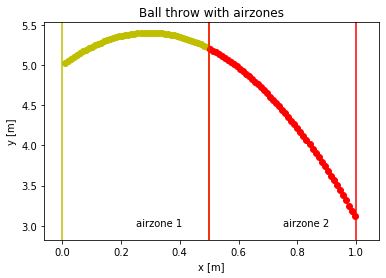

In [32]:
# Suppose we have to airzones through which the ball is being thrown:

# Define airzones
zone1 = box(0,0,0.5,6)
zone2 = box(0.5,0,1,6)

# We want to know which parts of the ball throw are in which airzones
ball_throw_gpd["airzone_1"] = None
ball_throw_gpd["airzone_2"] = None

USE_METHOD = "shapely" # or "apply"

if USE_METHOD == "shapely":
    
    # Which ball points are in which zone? Use a shapely function on the whole GeoDataFrame
    # Note: The operation is automatically carried out on the geometry column
    # 这两个是布尔list，实际上是pandas.core.series.Series
    ball_throw_gpd["airzone_1"] = ball_throw_gpd.within(zone1)
    ball_throw_gpd["airzone_2"] = ball_throw_gpd.within(zone2)

else:
    
    # Use the apply function to apply a arbitrary function to elements of a dataframe
    ball_throw_gpd["airzone_1"] = ball_throw_gpd.apply(func = lambda x: x.geometry.within(zone1), axis = 1)
    ball_throw_gpd["airzone_2"] = ball_throw_gpd.apply(func = lambda x: x.geometry.within(zone2), axis = 1)

# 这两个是路径
ball_throw_zone1_gpd = ball_throw_gpd[lambda x: x["airzone_1"]==True]
ball_throw_zone2_gpd = ball_throw_gpd[lambda x: x["airzone_2"]==True]

# Plot the result
# Note that an ax object has to be passed along the plots to not open a figure for every plot

# Plot the ball throw
ax = ball_throw_zone1_gpd.plot(color='y')
ball_throw_zone2_gpd.plot(ax =ax, color='red')

# Plot the airzones
ax.plot(*zone1.exterior.xy, color='y')
ax.plot(*zone2.exterior.xy, color='red')
ax.text(zone1.centroid.x, zone1.centroid.y, "airzone 1")
ax.text(zone2.centroid.x, zone2.centroid.y, "airzone 2")

# The general ball throw plotting framework
ax.set_aspect("auto")
setup_ball_throw_plot(ax.figure, title="Ball throw with airzones")


In [33]:
print(zone1)
print('------------')
print(ball_throw_gpd)
print('------------')
print(ball_throw_gpd["airzone_1"])
print('------------')
print(ball_throw_zone1_gpd)

POLYGON ((0.5 0, 0.5 6, 0 6, 0 0, 0.5 0))
------------
                     geometry  velocity  airzone_1  airzone_2
0.00  POINT (0.00000 5.00000)  3.000000      False      False
0.01  POINT (0.01026 5.02770)  2.908010       True      False
0.02  POINT (0.02052 5.05442)  2.816432       True      False
0.03  POINT (0.03078 5.08016)  2.725308       True      False
0.04  POINT (0.04104 5.10492)  2.634685       True      False
...                       ...       ...        ...        ...
0.95  POINT (0.97476 3.25136)  6.580903      False       True
0.96  POINT (0.98502 3.18587)  6.677821      False       True
0.97  POINT (0.99528 3.11939)  6.774773      False       True
0.98  POINT (1.00554 3.05193)  6.871757      False      False
0.99  POINT (1.01580 2.98350)  6.968773      False      False

[100 rows x 4 columns]
------------
0.00    False
0.01     True
0.02     True
0.03     True
0.04     True
        ...  
0.95    False
0.96    False
0.97    False
0.98    False
0.99    False
Name: airz